In [34]:
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray
import matplotlib.pyplot as plt
import xdem 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.optimize import lsq_linear
import geopandas as gpd
import seaborn as sns

## open datasets

In [2]:
data_path = '/mnt/Backups/gbrench/repos/rg_uavsar/data'

# open data 
ds = xr.open_dataset(f'{data_path}/combined/stack_20230725_20230925.zarr', chunks='auto', engine='zarr')
ds = ds.rio.write_crs('EPSG:32613')

ns_da = xr.open_dataarray(f'{data_path}/combined/ns_disp.tif').squeeze()
ew_da =xr.open_dataarray(f'{data_path}/combined/ew_disp.tif').squeeze()
ud_da =xr.open_dataarray(f'{data_path}/combined/ud_disp.tif').squeeze()

ds['ns_displacement'] = (('y', 'x'), ns_da.values)
ds['ew_displacement'] = (('y', 'x'), ew_da.values)
ds['ud_displacement'] = (('y', 'x'), ud_da.values)

In [3]:
# calculate total displacement and velocity
ds['total_displacement'] = np.sqrt(ds.ns_displacement**2 + ds.ew_displacement**2 + ds.ud_displacement**2)
ds['ns_velocity'] = (ds['ns_displacement']/62)*365.25
ds['ew_velocity'] = (ds['ew_displacement']/62)*365.25
ds['ud_velocity'] = (ds['ud_displacement']/62)*365.25
ds['total_velocity'] = (ds['total_displacement']/62)*365.25

In [4]:
ds['elevation'] = ds.height.mean(dim='swatch')

In [5]:
transform = (5.322144725472049309, 0.0, ds.elevation.isel(x=0, y=0).x.item(), 0.0, 5.322144725472049309, ds.elevation.isel(x=0, y=0).x.item())
# load to xdem
dem = xdem.DEM.from_array(ds.elevation.values, transform, crs='EPSG:32613')
# calculate slope 
ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)

/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


## first pass: single rock glacier

In [43]:
rg_fn = f'../mapping/polygons/example_rg1.shp'
rg_gdf = gpd.read_file(rg_fn)

In [44]:
rg_ds = ds.rio.clip(rg_gdf.geometry.values, crs=rg_gdf.crs, drop=True)

In [45]:
rg_ds = rg_ds.fillna(0)

In [46]:
# # Calculate the vector of horizontal components of landslide surface velocity
# rg_ds['usurf'] = np.sqrt(rg_ds['ew_velocity']**2 + rg_ds['ns_velocity']**2)

# # Define the constant f
# f = 0.75

# # Define the matrices and vectors for the linear system
# u_d = rg_ds['ud_velocity'].values.flatten()
# X = sp.diags([f * rg_ds['usurf'].values.flatten()], [0])
# b = rg_ds['usurf'].values.flatten() * rg_ds['slope'].values.flatten() - u_d

# # Define the regularization parameter and matrix
# lambda_ = 1
# T = sp.eye(len(u_d))  # Identity matrix for simplicity
# nabla2 = sp.diags([1, -2, 1], [-1, 0, 1], shape=(len(u_d), len(u_d)))

# # Define the system of equations
# A = sp.vstack([X, lambda_ * T @ nabla2])
# b = np.hstack([b, np.zeros(len(u_d))])

# # Solve the system with nonnegative constraints
# result = lsq_linear(A, b, bounds=(0, np.inf))

# # Reshape the solution to the original grid shape
# thickness = result.x.reshape(rg_ds['total_displacement'].shape)

# # Add the thickness to the dataset
# rg_ds['thickness'] = (('y', 'x'), thickness)

In [ ]:
def create_weighted_matrix_and_vector(x, y, u, v, bg, be, mask, ddx, numit):
    # Placeholder implementation for creating weighted matrix A and solution vector b
    nr, nc = mask.shape
    lenh = nr * nc
    Aw = np.random.rand(lenh, lenh)  # Replace with actual implementation
    bw = np.random.rand(lenh)  # Replace with actual implementation
    m = mask.flatten()
    xd, yd = x.flatten(), y.flatten()
    return Aw, bw, m, xd, yd

def generalized_cross_validation(Aw, bw, m, arange, numpts, plots):
    av = 10 ** np.linspace(arange[0], arange[1], numpts)
    nr, nc = m.shape
    lenh = nr * nc
    h = np.zeros((nr, nc, numpts))
    g = np.zeros(numpts)
    mpts = Aw.shape[0]

    for k in range(numpts):
        htemp, ri, _, B = lsd_overdet_lagrangian(Aw, bw, m, av[k])
        h[:, :, k] = htemp
        AA = Aw @ np.linalg.inv(Aw.T @ Aw + (av[k] ** 2) * B.T @ B) @ Aw.T
        I = np.eye(mpts)
        g[k] = mpts * (ri ** 2) / (np.trace(I - AA) ** 2)

    aq = np.linspace(np.log10(min(av)), np.log10(max(av)), 10000)
    gq = np.interp(aq, np.log10(av), g)
    abest = 10 ** aq[np.argmin(gq)]
    hbest = lsd_overdet_lagrangian(Aw, bw, m, abest)[0]

    if plots:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.semilogx(av, g, '-ok')
        plt.semilogx(10 ** aq, gq, 'r')
        plt.semilogx(abest, min(gq), 'xb')
        plt.xlabel('Damping Parameter')
        plt.ylabel('G Function')
        plt.show()

    return h, hbest, g, av, abest

In [ ]:
# Calculate the vector of horizontal components of landslide surface velocity
rg_ds['usurf'] = np.sqrt(rg_ds['ew_velocity']**2 + rg_ds['ns_velocity']**2)

# Define the constant f
f = 0.75  # Example value, adjust as needed

# Create weighted matrix A and solution vector b
Aw, bw, m, xd, yd = create_weighted_matrix_and_vector(rg_ds['x'], rg_ds['y'], rg_ds['ns_velocity'], rg_ds['ew_velocity'], rg_ds['ud_velocity'], rg_ds['slope'], rg_ds['mask'], 10, 1)

# Use generalized cross-validation to select the best damping parameter
numpts = 16
arange = [-1, 0]
plots = 1
h, hbest, g, a, abest = generalized_cross_validation(Aw, bw, m, arange, numpts, plots)

# Reshape the solution to the original grid shape
thickness = hbest.reshape(rg_ds['total_displacement'].shape)

# Add the thickness to the dataset
ds['thickness'] = (('y', 'x'), thickness)

In [47]:
rg_ds = rg_ds.rio.clip(rg_gdf.geometry.values, crs=rg_gdf.crs, drop=True)

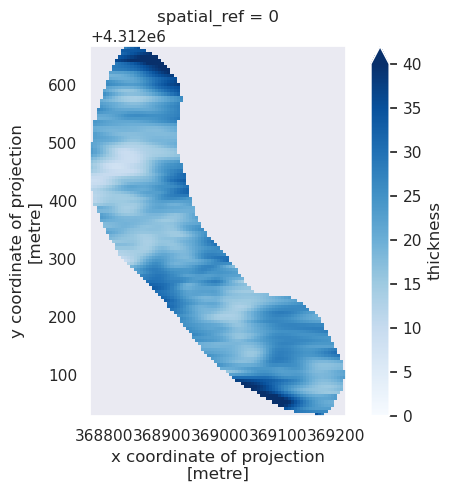

In [48]:
sns.set_theme()
f, ax = plt.subplots()
rg_ds.thickness.plot(ax=ax, vmin=0, vmax=40, cmap='Blues')
ax.set_aspect('equal')

In [49]:
rg_ds.thickness.rio.to_raster(f'{data_path}/combined/rg1_volume_thickness.tif', compress='LZW')